In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
from typing import Dict, Set, Optional, List
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# FIXME

# improve algorithm performance
# convert into script to run from command line
# create image with student names on seating chart
# if students request same group, keep them together

In [12]:
def compute_weighted_score(row, exam_columns, weights=None):
    """
    Compute weighted average score for a student. 
    By default, weight most recent exam scores more heavily.
    Custom weights should match the length of exam_columns.
    """
    scores = row[exam_columns].astype(float)
    valid = scores.notna()
    scores = scores[valid]

    if len(scores) == 0:
        return np.nan

    if weights is None:
        w = np.linspace(1.0, 1.3, len(scores))
    else:
        w = np.array(weights)[valid.values]

    return np.average(scores, weights=w)


def load_and_score_students(csv_path, exam_weights=None):
    """
    read student data and compute average scores
    """
    df = pd.read_csv(csv_path)
    exam_columns = [c for c in df.columns if c.lower().startswith("exam")]

    if exam_weights:
        weights = [exam_weights.get(c, 1.0) for c in exam_columns]
    else:
        weights = None

    df["avg_score"] = df.apply(
        compute_weighted_score,
        axis=1,
        exam_columns=exam_columns,
        weights=weights,
    )

    return df.dropna(subset=["avg_score"])


def build_pair_history(df: pd.DataFrame) -> Dict[str, Set[str]]:
    """
    Build student -> previously grouped-with set
    using all group* columns.
    Used to avoid repeat pairings.
    """
    history = defaultdict(set)
    group_cols = [c for c in df.columns if c.startswith("group")]

    for col in group_cols:
        for _, g in df.groupby(col):
            names = g["name"].dropna().tolist()
            for a in names:
                for b in names:
                    if a != b:
                        history[a].add(b)

    return history


def next_group_column(df: pd.DataFrame) -> str:
    """
    Determine the next group column name, ie group1, group2, etc.
    """
    group_cols = [c for c in df.columns if c.startswith("group")]
    if not group_cols:
        return "group1"

    nums = [int(c.replace("group", "")) for c in group_cols]
    return f"group{max(nums) + 1}"


def has_conflict(candidate: List[dict], history: Dict[str, Set[str]]) -> bool:
    """
    Prevent previous pairings in candidate group.
    """
    for i in range(len(candidate)):
        for j in range(i + 1, len(candidate)):
            if candidate[j]["name"] in history[candidate[i]["name"]]:
                return True
    return False

def build_pair_counts(df: pd.DataFrame) -> Dict[frozenset, int]:
    pair_counts = defaultdict(int)
    group_cols = [c for c in df.columns if c.startswith("group")]

    for col in group_cols:
        for _, g in df.groupby(col):
            names = g["name"].dropna().tolist()
            for i in range(len(names)):
                for j in range(i + 1, len(names)):
                    pair = frozenset([names[i], names[j]])
                    pair_counts[pair] += 1

    return pair_counts

def group_cost(students: List[dict], pair_counts, class_avg, alpha=10.0):
    """
    Cost = repeated pairings + penalty for score imbalance
    """
    # Pair repetition cost
    repeat_cost = 0
    for i in range(len(students)):
        for j in range(i + 1, len(students)):
            pair = frozenset([students[i]["name"], students[j]["name"]])
            repeat_cost += pair_counts.get(pair, 0)

    # Score balance cost
    group_avg = sum(s["avg_score"] for s in students) / len(students)
    balance_cost = abs(group_avg - class_avg)

    return repeat_cost + alpha * balance_cost


In [17]:
def assign_new_groups(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values("avg_score").copy()
    pair_counts = build_pair_counts(df)
    new_col = next_group_column(df)

    students = df.to_dict("records")
    n = len(students)
    class_avg = df["avg_score"].mean()


    # ---- GROUP COUNT LOGIC ----
    if n % 3 == 1:
        num_groups_of_two = 2
    elif n % 3 == 2:
        num_groups_of_two = 1
    else:
        num_groups_of_two = 0

    num_groups_of_three = (n - 2 * num_groups_of_two) // 3
    # --------------------------

    students_sorted = sorted(students, key=lambda s: s["avg_score"])

    group_assignments = {}
    group_id = 1

    # ---- GROUPS OF 3 ----
    low = students_sorted[:num_groups_of_three]
    mid = students_sorted[num_groups_of_three:2 * num_groups_of_three]
    high = students_sorted[2 * num_groups_of_three:3 * num_groups_of_three]

    random.shuffle(low)
    random.shuffle(mid)
    random.shuffle(high)

    used = set()

    for i in range(num_groups_of_three):
        best = None
        best_cost = float("inf")

        for m in mid:
            for h in high:
                candidate = [low[i], m, h]
                cost = group_cost(candidate, pair_counts, class_avg)
                if cost < best_cost and m["name"] not in used and h["name"] not in used:
                    best = candidate
                    best_cost = cost

        for s in best:
            group_assignments[s["name"]] = group_id
            used.add(s["name"])

        group_id += 1

    # ---- GROUPS OF 2 (BALANCED + ROTATING) ----
    remaining = [s for s in students_sorted if s["name"] not in used]

    while len(remaining) >= 2:
        best_pair = None
        best_cost = float("inf")

        for i in range(len(remaining)):
            for j in range(i + 1, len(remaining)):
                pair = [remaining[i], remaining[j]]
                cost = group_cost(pair, pair_counts, class_avg)

                if cost < best_cost:
                    best_cost = cost
                    best_pair = pair

        for s in best_pair:
            group_assignments[s["name"]] = group_id
            remaining.remove(s)

        group_id += 1

    df[new_col] = df["name"].map(group_assignments)
    return df



def run_grouping(
    csv_path: str,
    output_csv: str,
    exam_weights: Optional[Dict[str, float]] = None,
):
    """
    Main function to load data, compute scores, assign groups, and save output.
    """
    df = load_and_score_students(csv_path, exam_weights)
    df = assign_new_groups(df)
    # Sort df by the last group column
    last_group_col = df.columns[-1]
    df = df.sort_values(by=last_group_col)
    #save df
    df.to_csv(output_csv, index=False)
    return df


In [18]:
df = run_grouping(
    csv_path="students.csv",
    output_csv="students_grouped.csv"
)
df

,name,exam1,exam2,exam3,avg_score,group1
0,Diana,64,68,70,67.594203,1
5,Evan,81,84,86,83.884058,1
8,Fiona,90,91,93,91.463768,1
2,George,70,73,75,72.884058,2
4,Ian,78,80,82,80.173913,2
7,Alice,88,90,92,90.173913,2
1,Kevin,67,69,71,69.173913,3
3,Bob,72,75,78,75.260870,3
6,Hannah,85,87,89,87.173913,3
9,Julia,92,94,96,94.173913,4


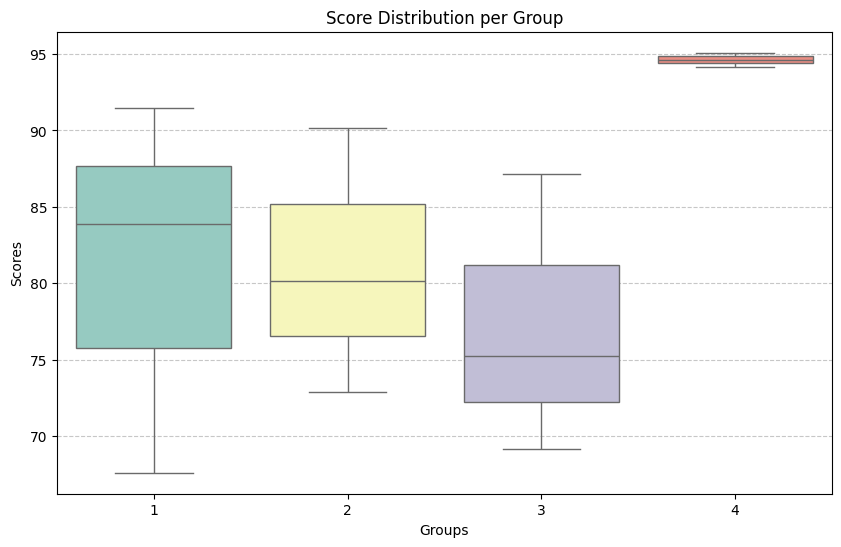

In [19]:
def plot_group_score_distribution(df):
    """
    Plot a boxplot to visualize the score distribution per group.
    """
    # Get the last group column
    last_group_col = df.columns[-1]

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=last_group_col, y='avg_score', data=df, hue=last_group_col, palette='Set3', legend=False)

    # Add labels and title
    plt.xlabel('Groups')
    plt.ylabel('Scores')
    plt.title('Score Distribution per Group')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()

plot_group_score_distribution(df)